SVR Model:
Mean Squared Error: 16.481043927386782
Accuracy: 99.28837933520832 

RandomForestRegressor Model:
Mean Squared Error: 15.06876652466138
Accuracy: 99.27332630405877 

GradientBoostingRegressor Model:
Mean Squared Error: 17.735578386390632
Accuracy: 99.23761019412517 

LinearRegression Model:
Mean Squared Error: 10.08598276065066
Accuracy: 99.40606545985392 



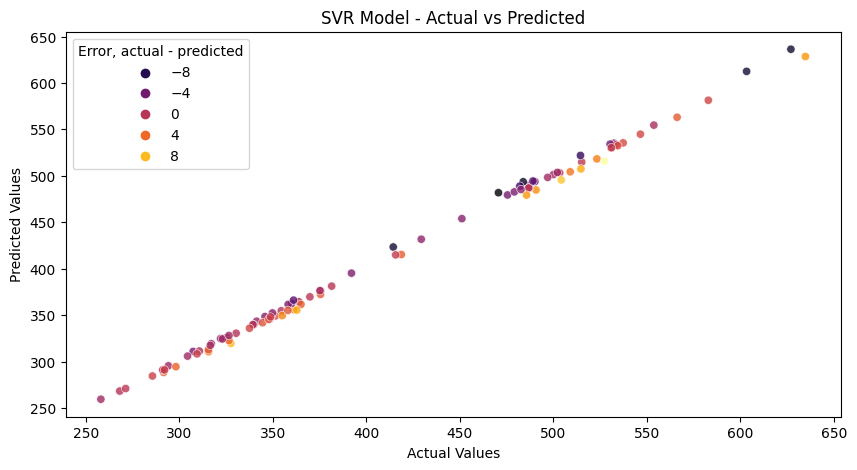

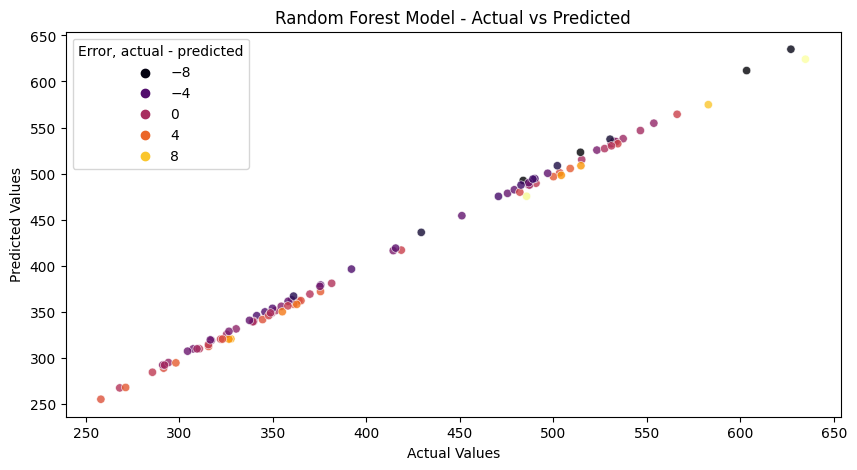

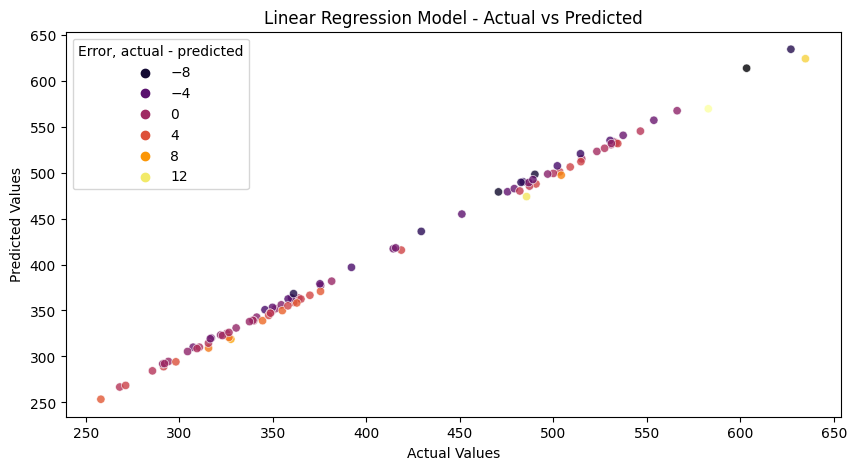

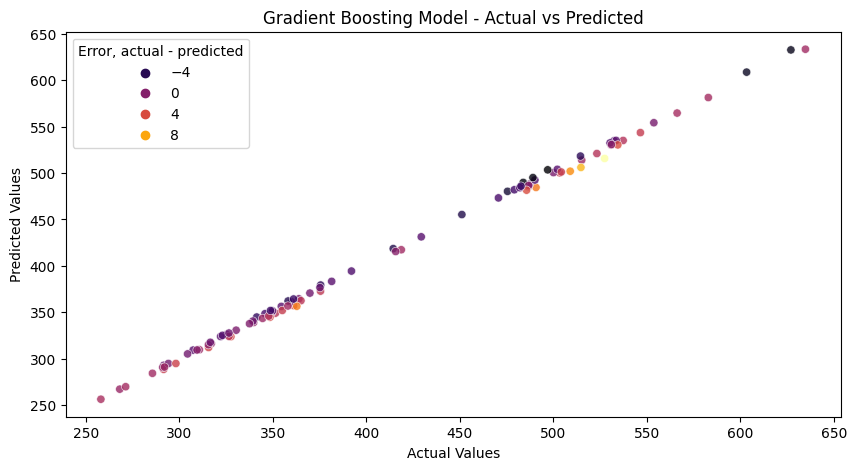

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

def accuracy(y_true, y_pred):
    errors = abs(y_true - y_pred)
    mape = 100 * np.mean(errors / y_true)
    accuracy = 100 - mape
    return accuracy

def preprocess_data(data):
    data['Volume'] = winsorize(data['Volume'], limits=[0.05, 0.95])
    data['Volume'] = np.log(data['Volume'] + 1)
    columns_order = ['Day', 'Month', 'Year', 'Open', 'Low', 'High', 'Volume','is_quarter_end', 'Near_Support', 'Near_Resistance', 'Close_EMA_50', 'Close']
    return data[columns_order]

def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    accuracy_percentage = accuracy(y_test, predictions)
    print(f"{model.__class__.__name__} Model:")
    print("Mean Squared Error:", mse)
    print("Accuracy:", accuracy_percentage, "\n")
    return predictions

def visualize_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    residuals = actual - predicted
    sns.scatterplot(x=actual, y=predicted, hue=residuals, palette='inferno', alpha=0.8)
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend(title='Error, actual - predicted')
    plt.show()


def identify_support_resistance(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Near_Support'] = np.where(data['Close'] <= data['SMA_50'], 1, 0)
    data['Near_Resistance'] = np.where(data['Close'] >= data['SMA_200'], 1, 0)
    return data

def load_and_process_data(file_path):
    data = pd.read_excel(file_path)
    data.drop('Adj Close', axis=1, inplace=True)
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data['is_quarter_end'] = np.where(data['Month'] % 3 == 0, 1, 0)
    data.drop('Date', axis=1, inplace=True)
    data['Close_EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data = identify_support_resistance(data)
    data = preprocess_data(data)
    data.dropna(inplace=True)
    y = data['Close'][:-49]
    X = data[['Open', 'Low', 'High', 'Volume', 'is_quarter_end', 'Near_Support', 'Near_Resistance', 'Close_EMA_50']][:-49]
    return X, y

file_path = '/content/drive/MyDrive/corizo_projects/StockMarket/StockMarket.xlsx'
X, y = load_and_process_data(file_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=530)

models = [
    SVR(kernel='rbf', C=100, epsilon=0.1),
    RandomForestRegressor(n_estimators=100, min_samples_split=3),
    GradientBoostingRegressor(),
    LinearRegression()
]

predictions = []

for model in models:
    model_predictions = train_evaluate_model(model, X_train, X_test, y_train, y_test)
    predictions.append(model_predictions)

model_names = ["SVR Model", "Random Forest Model", "Linear Regression Model", "Gradient Boosting Model"]
for i, prediction in enumerate(predictions):
    visualize_predictions(y_test, prediction, model_names[i])